In [8]:
import google.generativeai as genai
import PIL.Image
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
genai.configure(api_key="")

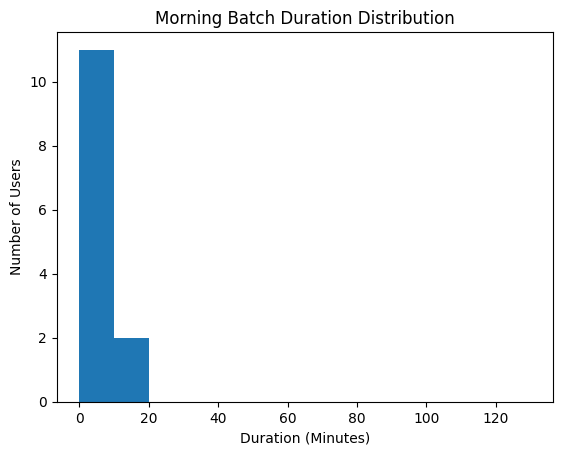

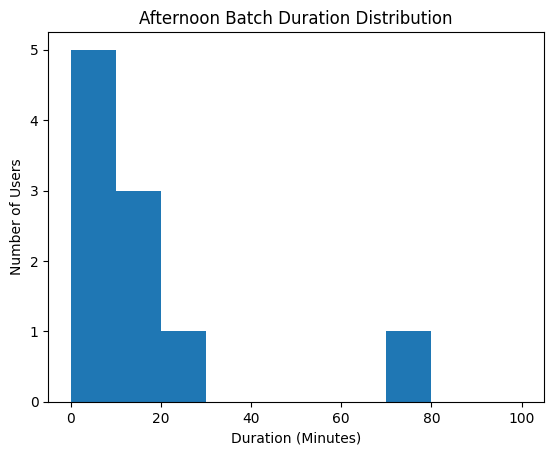

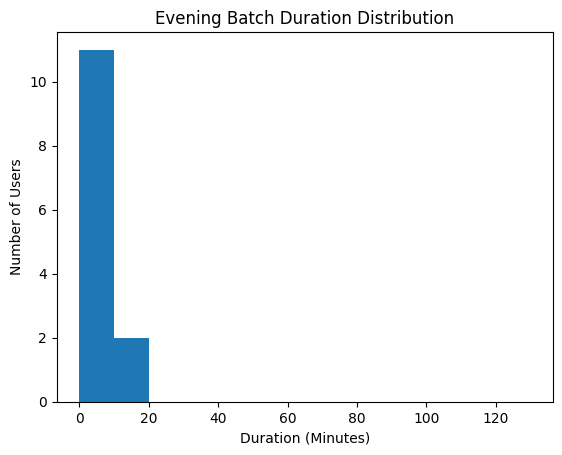

It seems you're trying to analyze attendance data for different batches (Morning, Afternoon, Evening) but the provided data lacks the crucial information needed to identify which students belong to each batch. 

To provide meaningful summary reports, I need the following:

* **Batch Affiliation:** A way to identify which batch each student belongs to. This could be:
    * A column in your data labeled "Batch" with values like "Morning," "Afternoon," "Evening."
    * A separate list or table mapping student names to their respective batches. 

**Once I have the batch affiliation data, I can provide you with the detailed summary reports you requested, including:**

**For Each Batch (Morning, Afternoon, Evening):**

* **Total Duration of Attendance:** Sum of the "TotalDuration" values for all students in the batch.
* **Average Duration of Attendance:** Mean "TotalDuration" for all students in the batch.
* **Standard Deviation of Attendance Duration:** A measure of how spread out the atten

In [12]:
class AttendanceAnalyzer:
    def __init__(self, files):
        self.files = files
        self.dfs = [pd.read_csv(file) for file in files]


    def get_llm_analysis(self, prompt, data=None, llm_model="Gemini"):
        """Uses Gemini for analysis, including data if provided."""
        if data is not None:
            if isinstance(data, pd.DataFrame):
                data_str = data.to_markdown(index=False, numalign="left", stralign="left")
            else:
                import json
                data_str = json.dumps(data, indent=4)
            prompt += f"\n\nData:\n{data_str}"

        model = genai.GenerativeModel(
            'gemini-1.5-flash',
            generation_config=genai.GenerationConfig(
                max_output_tokens=2000,
                temperature=0.9,
            ))
        response = model.generate_content(
            prompt, generation_config=genai.GenerationConfig(stop_sequences=['\n6']))

        return response.text

    def analyze_batch(self, batch_name, data):
        prompts = [
            f"Calculate the total duration of attendance for the {batch_name} batch.",
            f"Calculate the average duration of attendance for the {batch_name} batch.",
            f"Calculate the standard deviation of attendance duration for the {batch_name} batch.",
            f"Calculate the percentage of users who attended more than the average duration for the {batch_name} batch.",
        ]

        results = {}
        for prompt in prompts:
            result = self.get_llm_analysis(prompt, data)
            results[prompt] = result

        # Duration Buckets Distribution (Local Calculation, No LLM)
        bins = range(0, int(data['TotalDuration'].max()) + 11, 10)  # 0-10, 10-20, etc.
        hist, _ = np.histogram(data['TotalDuration'], bins=bins)
        plt.hist(hist, bins=bins)
        plt.xlabel('Duration (Minutes)')
        plt.ylabel('Number of Users')
        plt.title(f'{batch_name} Batch Duration Distribution')
        plt.show()

        return results

    def analyze_all(self):
        batch_names = ["Morning", "Afternoon", "Evening"]
        all_results = {}

        # Grouping and Summarization
        grouped_data = []
        for df in self.dfs:
            grouped_data.append(
                df.groupby("Name (Original Name)")
                .agg(TotalDuration=("Duration (Minutes)", "sum"))
                .reset_index()
            )

        for i, (batch, data) in enumerate(zip(batch_names, grouped_data)):
            batch_results = self.analyze_batch(batch, data)
            all_results[batch] = batch_results

        # Combined Summary and Comparative Analysis (LLM Prompts)
        combined_prompts = [
            "Generate detailed summary reports for each batch (morning, afternoon, evening).",
            "Generate a combined summary report comparing all three batches.",
        ]

        for prompt in combined_prompts:
            result = self.get_llm_analysis(prompt, all_results)
            print(result)


if __name__ == "__main__":
    files = ["/content/Afternoon-28th-June.csv", "/content/Evening-28th-June.csv", "/content/Afternoon-28th-June.csv"]
    analyzer = AttendanceAnalyzer(files)
    analyzer.analyze_all()